# 第3章 最尤推定法：確率を用いた推定理論

## 「03-maximum_likelihood.py」の解説

ITエンジニアための機械学習理論入門「第3章 最尤推定法：確率を用いた推定理論」で使用しているサンプルコード「03-maximum_likelihood.py」の解説です。

※ 解説用にコードの内容は少し変更しています。

はじめに必要なモジュールをインポートしておきます。

関数 normal は、正規分布に従う乱数を生成するために利用します。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

from numpy.random import normal

正弦関数に正規分布のノイズを載せたデータセットを生成する関数を定義します。

これは、0≦x≦1 の区間を等分した num 個の点 x に対して、対応する y の値を生成します。

In [2]:
# データセット {x_n,y_n} (n=1...num) を用意
def create_dataset(num):
    dataset = DataFrame(columns=['x','y'])
    for i in range(num):
        x = float(i)/float(num-1)
        y = np.sin(2*np.pi*x) + normal(scale=0.3)
        dataset = dataset.append(Series([x,y], index=['x','y']),
                                 ignore_index=True)
    return dataset

例として、10個のデータをトレーニングセットとして生成します。

In [3]:
N=10            # サンプルを取得する位置 x の個数
train_set = create_dataset(N)
train_set

,x,y
0,0.000000,0.105366
1,0.111111,0.749869
2,0.222222,1.364159
3,0.333333,0.855806
4,0.444444,0.722803
5,0.555556,0.322061
6,0.666667,-1.116827
7,0.777778,-1.170610
8,0.888889,-0.981598
9,1.000000,0.345182


x と y の値のリストは、train_set.x と train_set.y で取得できます。

グラフ上にプロットすると次のようになります。

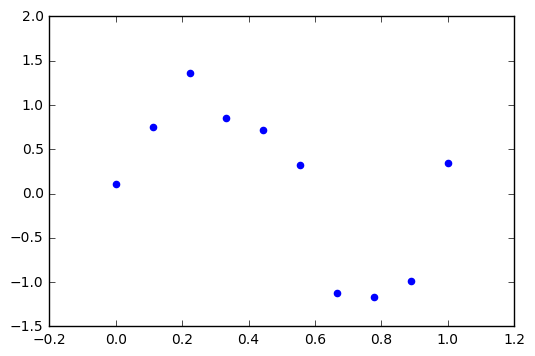

In [4]:
plt.scatter(train_set.x, train_set.y, marker='o', color='blue')

このデータに対して、最尤推定法でフィッティングした m 次多項式と標準偏差を決定する関数を用意します。

引数 dataset と m にトレーニングセットと多項式の次数を代入すると、多項式に対応する関数 f(x) のオブジェクトと標準偏差の値が返ります。

In [5]:
def resolve(dataset, m):
    t = dataset.y
    phi = DataFrame()
    for i in range(0,m+1):
        p = dataset.x**i
        p.name="x**%d" % i
        phi = pd.concat([phi,p], axis=1)
    tmp = np.linalg.inv(np.dot(phi.T, phi))
    ws = np.dot(np.dot(tmp, phi.T), t)

    def f(x):
        y = 0.0
        for i, w in enumerate(ws):
            y += w * (x ** i)
        return y

    sigma2 = 0.0
    for index, line in dataset.iterrows():
        sigma2 += (f(line.x)-line.y)**2
    sigma2 /= len(dataset)

    return (f, np.sqrt(sigma2))

また、得られた関数 f(x) に対して、トレーニングセットに対する最大対数尤度を求める関数を用意します。

In [6]:
# 最大対数尤度（Maximum log likelihood）を計算
def log_likelihood(dataset, f):
    dev = 0.0
    n = float(len(dataset))
    for index, line in dataset.iterrows():
        x, y = line.x, line.y
        dev += (y - f(x))**2
    err = dev * 0.5
    beta = n / dev
    lp = -beta*err + 0.5*n*np.log(0.5*beta/np.pi)
    return lp

これらを用いて、結果をグラフに可視化する関数が次になります。

In [7]:
def show_result(subplot, train_set, m):
    f, sigma = resolve(train_set, m)
    subplot.set_xlim(-0.05,1.05)
    subplot.set_ylim(-1.5,1.5)
    subplot.set_title("M=%d" % m, fontsize=10)

    # トレーニングセットを表示
    subplot.scatter(train_set.x, train_set.y, marker='o',
                    color='blue', label=None)

    # 真の曲線を表示
    linex = np.linspace(0,1,101)
    liney = np.sin(2*np.pi*linex)
    subplot.plot(linex, liney, color='green', linestyle='--')

    # 多項式近似の曲線を表示
    linex = np.linspace(0,1,101)
    liney = f(linex)
    label = "Sigma=%.2f" % sigma
    subplot.plot(linex, liney, color='red', label=label)
    subplot.plot(linex, liney+sigma, color='red', linestyle='--')
    subplot.plot(linex, liney-sigma, color='red', linestyle='--')
    subplot.legend(loc=1, fontsize=10)

先ほど生成したトレーニングセットを用いて、0, 1, 3, 9次多項式（定数関数）でフィッティングした結果を表示します。

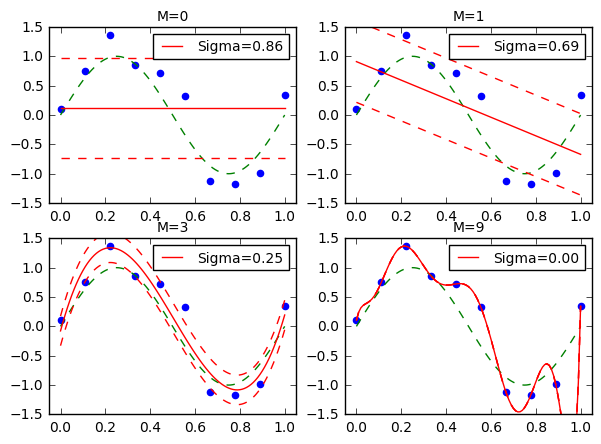

In [8]:
fig = plt.figure(figsize=(7, 5))
for i, m in enumerate([0,1,3,9]):
    subplot = fig.add_subplot(2,2,i+1)
    show_result(subplot, train_set, m)

多項式の次数が上がるにつれてデータポイントの近くを通るようになり、標準偏差が減少していることがわかります。

ここで、トレーニングセットとテストセットに対する対数尤度の変化を確認します。

多項式の次数を0〜9に変化させながら、対数尤度のグラフを描く関数を用意します。（次数が10の場合は、オーバーフィッティングにより対数尤度が無限大に発散します。

In [9]:
# 多項式近似に対する最大対数尤度を計算
def show_loglikelihood_trend(train_set, test_set):
    df = DataFrame()
    train_mlh = []
    test_mlh = []
    for m in range(0,9): # 多項式の次数
        f, sigma = resolve(train_set, m)
        train_mlh.append(log_likelihood(train_set, f))
        test_mlh.append(log_likelihood(test_set, f))
    df = pd.concat([df,
                    DataFrame(train_mlh, columns=['Training set']),
                    DataFrame(test_mlh, columns=['Test set'])],
                    axis=1)
    df.plot(title='Log likelihood for N=%d' % N, grid=True, style=['-','--'])

トレーニングセットとは独立に生成したテストセットを用意します。

In [10]:
test_set = create_dataset(N)
test_set

,x,y
0,0.000000,0.164234
1,0.111111,0.528519
2,0.222222,1.622182
3,0.333333,1.010174
4,0.444444,0.598629
5,0.555556,-0.301927
6,0.666667,-0.566924
7,0.777778,-0.549854
8,0.888889,-0.911291
9,1.000000,0.285287


多項式の次数を0〜9に変化させながら、トレーニングセットとテストセットに対する対数尤度を計算して、結果をグラフ表示します。

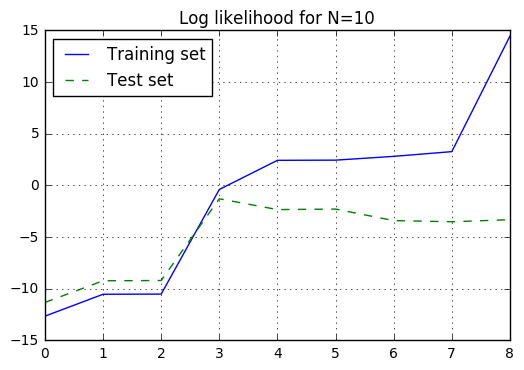

In [11]:
show_loglikelihood_trend(train_set, test_set)